# Projet 7 : Analyse de sentiment sur une base de données de tweets

La problématique client est la suivante : comment analyser rapidement une grande quantité de tweets ?

Pour répondre a cette problématique, nous réaliserons une IA capable d'apprendre le sentiment présent dans un tweet.

Les modèles suivant sont utilisés :
 
* 1 modèle simple LogisticRegression
* 2 modele sur mesure CNN
    * 2.1 pretraitement optimal (aucun, simple, avancé, avancé et lemmatization)
    * 2.2 embedding optimal (aucun, glove, google)
* 3 modèle sur mesure BiLSTM
* 4 modèle BERT


In [7]:
# Basic utilities
import os
import re
from string import punctuation
from collections import Counter, defaultdict

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Word embeddings
from gensim.models import Word2Vec,KeyedVectors

# Machine Learning
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix,roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM, Conv1D, GlobalMaxPooling1D, Dropout,SpatialDropout1D,Dense,\
                                    MaxPooling1D, TextVectorization, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from keras.backend import clear_session

# Experiment tracking
import mlflow
import mlflow.keras


# Natural Language Processing
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords, wordnet
from nltk.tag import pos_tag

from datetime import datetime

import pickle
import json

print( "Import completed !")
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('words')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

Import completed !


[nltk_data] Downloading package stopwords to /home/cc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/cc/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package words to /home/cc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/cc/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/cc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Définition des fonctions

In [11]:

os.environ['MLFLOW_TRACKING_URI'] = 'http://0.0.0.0:8000'


# Load and preprocess the custom dataset
def prepro_data(df, feat, label):
    
    # Recupere seulement n tweet
    df_positive = df[df[label] == 0].head(int(model_config['n_sample']/2))
    df_negative = df[df[label] == 1].head(int(model_config['n_sample']/2))
    df = pd.concat([df_positive, df_negative])
    
    
    # avant prepro
    for i in df[feat][0:3]:
        print(i+'\n')
        
    # prepro la colonne de tweets    
    df[feat] = df[feat].apply(lambda x: cleaner(x)) 
   
    # apres prepro    
    for i in df[feat][0:3]:
        print(i+'\n')
    
    
    x = df[feat]
    y = df[label]
    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        train_size=0.8, 
                                                        shuffle=True,
                                                        stratify=y,
                                                        random_state=42,)
    
    
    print(f"x_train shape : {len(x_train)}")
    print(f"y_train shape : {len(y_train)}")
    print(f"x_test shape : {len(x_test)}")
    print(f"y_test shape : {len(y_test)}")
    
    return x_train, y_train, x_test, y_test

def cleaner(text) :     

    if model_config['preprocessing'] == 'simple' :
        
        text = text.lower()
        # tokenization 
        tokens = nltk.word_tokenize(text) 
        # remove puncs 
        punc = list(punctuation)
        tokens = [word for word in tokens if word not in punc]
        # remove stopwords 
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if  word not in stop_words]
        text = ' '.join(tokens)
        
    if model_config['preprocessing'] == 'advanced' :

            text = text.lower()

            text = re.sub('<.*?>', '', text) # HTML tags
            text = re.sub(r'\d+', '', text) # numbers
            text = re.sub(r'[^\w\s]', '', text) # special characters
            text = re.sub(r'http\S+', '', text) # URLs or web links
            text = re.sub(r'@\S+', '', text) # mentions
            text = re.sub(r'#\S+', '', text) # hashtags

            # tokenization 
            tokens = nltk.word_tokenize(text) 
            # remove puncs 
            punc = list(punctuation)
            tokens = [word for word in tokens if word not in punc]
            # remove stopwords 
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stop_words]
            text = ' '.join(tokens)        
        
        
        
    if model_config['preprocessing'] == 'advanced_lemma' :
            
            text = text.lower()

            text = re.sub('<.*?>', '', text) # HTML tags
            text = re.sub(r'\d+', '', text) # numbers
            text = re.sub(r'[^\w\s]', '', text) # special characters
            text = re.sub(r'http\S+', '', text) # URLs or web links
            text = re.sub(r'@\S+', '', text) # mentions
            text = re.sub(r'#\S+', '', text) # hashtags

            # tokenization 
            tokens = nltk.word_tokenize(text) 
            # remove puncs 
            punc = list(punctuation)
            tokens = [word for word in tokens if word not in punc]
            # remove stopwords 
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if  word not in stop_words]
            
            lemmatizer = WordNetLemmatizer() 
            wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
            pos_tagged_text = pos_tag(tokens)
            l_lem = [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]
            
            text = ' '.join(l_lem)
            
        
    return text




# Build the model
def build_model():    
    
    vectorizer = TextVectorization(max_tokens = 20000,
                                   output_sequence_length=200,
                                   output_mode ='int')
    
    train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
    
    print("Begining vectorizer.adapt() ")

    vectorizer.adapt(train_dataset)    
    voc = vectorizer.get_vocabulary()
    print(len(voc) + 2)
    
    VOCAB_SIZE = len(voc) + 2 
    EMBEDDING_DIM = 100
    
    current_date = datetime.now().strftime("%Y_%m_%d")

    # # Construire le nom du fichier
    # file_name = f"{current_date}_vectorizer.json"
    # 
    # with open(file_name, 'w') as f:
    #     json.dump({'config': vectorizer.get_config(),
    #                'weights': vectorizer.get_weights()}, f)
    
    print('Building model ...')

    [print(i,':\t',model_config[i]) for i in model_config]


    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    
    
    model.add(vectorizer)
    
    print(model_config['pre_trained_embeddings'])
    print( model_config['pre_trained_embeddings'] == 'glove200')
    
    if model_config['pre_trained_embeddings'] == 'aucun' :
        embedding_layer = Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        trainable=True)
        
    if model_config['pre_trained_embeddings'] == 'glove200' :      
        
        path_to_glove_file = "./glove.twitter.27B.200d.txt"

        embeddings_index = {}
        with open(path_to_glove_file, encoding='utf-8') as f:
            for line in f:
                word, coefs = line.split(maxsplit=1)
                coefs = np.fromstring(coefs, "f", sep=" ")
                embeddings_index[word] = coefs

        print("Loading %s word vectors from glove." % len(embeddings_index))

        display(len(vectorizer.get_vocabulary()))
        display(vectorizer.get_vocabulary()[:5])
        voc = vectorizer.get_vocabulary()
        word_index = dict(zip(voc, range(len(voc))))

        print(len(voc) + 2)
        VOCAB_SIZE = len(voc) + 2
        EMBEDDING_DIM = 200
        hits = 0
        misses = 0
        # Prepare embedding matrix
        embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in embedding index will be all-zeros.
                # This includes the representation for "padding" and "OOV"
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
        print(f"Converted {hits} words ({misses} misses), {round(hits/(hits + misses) * 100)} %")
        

        
        embedding_layer = Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=True)

        
    if model_config['pre_trained_embeddings'] == 'google300' :

        word2vec_path = './GoogleNews-vectors-negative300.bin'  # Update the path to your downloaded model
        word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

        voc = vectorizer.get_vocabulary()
        word_index = dict(zip(voc, range(len(voc))))
        for i, (w, index) in enumerate(word_index.items()):
            if i < 5:
                print(w, index)
        # Constants
        VOCAB_SIZE = len(voc) + 2
        EMBEDDING_DIM = 300
        hits = 0
        misses = 0
        # Prepare embedding matrix
        embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
        for word, i in word_index.items():
            if word in word2vec_model:
                try:
                    embedding_vector = word2vec_model[word]
                    embedding_matrix[i] = embedding_vector
                    hits += 1
                except KeyError:
                    misses += 1
        print(f"Converted {hits} words ({misses} misses), {round(hits/(hits + misses) * 100)} %")


        embedding_layer = Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=True)
            
    model.add(embedding_layer)
   

    if model_config['model_type'] == 'CNN':
        model.add(Conv1D(128, 7, activation='relu', strides=3))
        model.add(Conv1D(128, 7, activation='relu', strides=3))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        
    if model_config['model_type'] == 'LSTM':
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))


    model.add(Dense(1, activation='sigmoid', name='predictions'))
    
    model.summary()    

    return model



# Compile the model
def compile_model(model):
    print('Compiling model ...')
    model.compile(optimizer=Adam(learning_rate=model_config['l_r']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=4,
                                   verbose=1)
    model_checkpoint = ModelCheckpoint('best_model.keras',
                                       save_best_only=True,
                                       monitor='val_loss',
                                       verbose=1)
    return [early_stopping, model_checkpoint]

# Train the model
def train_eval_model(model, x_train, y_train, x_test, y_test):
    print('Start training ...')
    callbacks = get_callbacks()
    with mlflow.start_run(run_name=model_config['model_type']+'_'+model_config['preprocessing']+ \
                          '_'+model_config['pre_trained_embeddings']):
        clear_session()
        history = model.fit(x_train, y_train,
                            epochs=50,
                            batch_size=32,
                            validation_split=0.2,
                            callbacks=callbacks)
        
        pred_serie = pd.DataFrame(model.predict(x_test))
        y_pred = pred_serie.iloc[:,0].map(lambda x : 1 if x > 0.5 else 0)
        
        accuracy = round(accuracy_score(y_test, y_pred),4)
        auc = round(roc_auc_score(y_test, pred_serie),4) 
        
        mlflow.keras.log_model(model, "model")        
        mlflow.log_metric("Test Accuracy", accuracy)
        mlflow.log_metric("Test Auc", auc)
        mlflow.log_params(model_config)  # Log model configuration
    
        print("Test_Accuracy", accuracy)
        print("Test_Auc", auc)
        
    return history


# Plot accuracy and AUC
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
def top_words(corpus, n=10):
    # Initialiser TfidfVectorizer avec suppression des stopwords
    stop_words = stopwords.words('english')  # Récupérer la liste de stopwords en anglais
    vectorizer = TfidfVectorizer(stop_words=stop_words)  # Ajout de stopwords ici

    # Transformer le corpus en matrice de termes TF-IDF
    X = vectorizer.fit_transform(corpus)

    # Récupérer les noms des termes
    terms = vectorizer.get_feature_names_out()

    # Calculer les scores TF-IDF moyens pour chaque terme
    tfidf_scores = X.mean(axis=0).A1

    # Créer un dictionnaire des termes et de leurs scores TF-IDF
    word_tfidf = {terms[i]: tfidf_scores[i] for i in range(len(terms))}

    # Trier les termes par scores TF-IDF
    sorted_word_tfidf = sorted(word_tfidf.items(), key=lambda item: item[1], reverse=True)

    # Afficher les n premiers mots avec leurs scores TF-IDF
    for word, score in sorted_word_tfidf[:n]:
        print(f"{word}: {score}")

    # Créer un dictionnaire pour WordCloud
    wordcloud_data = {word: score for word, score in sorted_word_tfidf[:n]}

    # Générer le WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

    # Afficher le WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    
    

# Chargement du dataset


In [4]:


dataset_filename = os.listdir("./input")[0]
dataset_path = os.path.join("./", "input", dataset_filename)
print("Open file:", dataset_path)

DATASET_COLUMNS = ["labels", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(dataset_path,
                 encoding=DATASET_ENCODING,
                 names=DATASET_COLUMNS)
df['labels'] = df['labels'].replace(4, 1)

print(df['labels'].unique())


Open file: ./input/tweet.csv
[0 1]


Visualisons les principaux mots qui composent nos tweets.

good: 0.01106626553295689
day: 0.010848191488693324
work: 0.009679030992946201
go: 0.009143912289395642
get: 0.009054527980740643
today: 0.008906630051744347
like: 0.00861898228093832
going: 0.00853674584709442
love: 0.00790773294237533
quot: 0.0077519717566602725
back: 0.007649347165958942
got: 0.007385645684724325
time: 0.007325307162369786
lol: 0.00684758763050343
http: 0.0067834230738960275
really: 0.006675378901863915
im: 0.0065602113791635615
know: 0.00652267348822832
one: 0.006495398440076249
home: 0.006222588212766624
want: 0.006121013714632183
night: 0.0061088486691096575
see: 0.005884100585794486
still: 0.005821702314657517
morning: 0.005634888437369335
well: 0.00560832892576033
new: 0.005518016968417916
thanks: 0.0055153359847233486
miss: 0.005501500109639766
com: 0.005469604905912902
think: 0.005372600543246782
oh: 0.00528646425579893
amp: 0.00518887547798034
tomorrow: 0.005137802158125934
twitter: 0.005131383983707538
much: 0.005088695213173131
need: 0.0049460064649382495


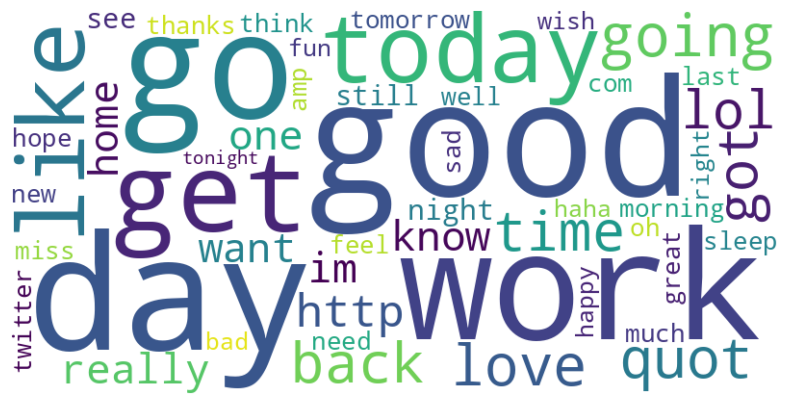

In [13]:
top_words(df["text"],50)

Afin de mieux comprendre le fonctionnement de textvectorization, réalisons un test simple :

In [5]:
x_train=['je mange bien', 'je mange beaucoup']
x_test=['je mange trop', 'je mange beaucoup']

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=10)
vectorizer.adapt(x_train)    

x_train_vec = vectorizer(x_train)
x_test_vec = vectorizer(x_test) 

I0000 00:00:1726003111.785684     702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726003111.862927     702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726003111.862966     702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726003111.865787     702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726003111.865821     702 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [6]:
x_train_vec

<tf.Tensor: shape=(2, 10), dtype=int64, numpy=
array([[3, 2, 4, 0, 0, 0, 0, 0, 0, 0],
       [3, 2, 5, 0, 0, 0, 0, 0, 0, 0]])>

In [7]:
x_test_vec

<tf.Tensor: shape=(2, 10), dtype=int64, numpy=
array([[3, 2, 1, 0, 0, 0, 0, 0, 0, 0],
       [3, 2, 5, 0, 0, 0, 0, 0, 0, 0]])>


# Modèles LR sklearn avec suivi mlflow

Dans cette partie, nous réalisons un modèle simple de régression logistique avec la library scikit-learn.
Nous réalisons un pipeline avec une extraction de feature via TF-IDF puis nous trouvons les meilleurs hyperparamètres grace à gridsearch.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model_config = {
                'model_type': 'LR',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "None",   
                'n_sample' : 1200000,
                'l_r' : "-",
                }

x_train, x_test, y_train, y_test = train_test_split(df['text'],
                                                    df['labels'],
                                                    train_size=int(model_config['n_sample']*0.8),
                                                    test_size=int(model_config['n_sample']*0.2),
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=df['labels'])

print(f"x_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape}")
print(f"y_test shape : {y_test.shape}")

[print(i,':\t',model_config[i]) for i in model_config]



display(x_train.head())
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Convert text to TF-IDF vectors
    ('clf', LogisticRegression(max_iter=1000))  # Logistic Regression classifier
])

# Define the parameter grid
param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear']  # 'liblinear' is used for l1 and l2 penalties
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

with mlflow.start_run(run_name='LR_GridSearch') as run:

    # Perform grid search
    grid_search.fit(x_train, y_train)

    # Get the best parameters and estimator
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_estimator.predict(x_test)

    # Evaluate the model
    report = classification_report(y_test, y_pred)
    print(report)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=best_estimator.named_steps['clf'].classes_)

    # Display the confusion matrix with seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_estimator.named_steps['clf'].classes_, yticklabels=best_estimator.named_steps['clf'].classes_)
    plt.xlabel('Predictions')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute test accuracy
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, best_estimator.predict_proba(x_test)[:,1])
    
    mlflow.log_metric('Test Accuracy', acc)
    mlflow.log_metric('Test Auc', auc)
    
    mlflow.sklearn.log_model(best_estimator, "best_model")
        

x_train shape : (960000,)
y_train shape : (960000,)
x_test shape : (240000,)
y_test shape : (240000,)
model_type :	 LR
preprocessing :	 aucun
pre_trained_embeddings :	 None
n_sample :	 1200000
l_r :	 -


1233203    thx@MJIC: &quot;&gt;100Listeners!thk you all  ...
428015                               Ergh miserable weather 
1421248    @lizmoney Apple's in-ears are slightly comfy f...
1080336    Looking forward to meeting you (@unmarketing) ...
127292                     @nickblah49 100!?? Mines only 54 
Name: text, dtype: object

Fitting 5 folds for each of 10 candidates, totalling 50 fits


# Modèles CNN avec suivi mlflow

## Modele sans preprocessing

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

x_train shape : 1280000
y_train shape : 1280000
x_test shape : 320000
y_test shape : 320000
Begining vectorizer.adapt() 


2024-09-09 23:42:49.195623: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20002
Building model ...
model_type :	 CNN
preprocessing :	 aucun
pre_trained_embeddings :	 aucun
n_sample :	 1600000
l_r :	 5e-05
aucun
False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 65, 128)        │        89,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,221,385 (8.47 MB)

 Trainable params: 2,221,385 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...
Epoch 1/50


2024-09-09 23:43:13.450040: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1725918193.606355  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918193.637801  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918193.641720  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918193.649436  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918193.651404  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918193.655521  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918193.664347  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918193.668345  478928 gpu_t

    8/32000 ━━━━━━━━━━━━━━━━━━━━ 8:32 16ms/step - accuracy: 0.5094 - loss: 0.6933 

W0000 00:00:1725918194.791645  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918194.795874  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918194.797674  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918194.799182  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918194.801356  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918194.803734  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918194.805649  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918194.807324  478928 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918194.809110  478928 gp

31998/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7454 - loss: 0.4998

W0000 00:00:1725918503.568230  478930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918503.568938  478930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918503.569378  478930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918503.569804  478930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918503.570190  478930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918503.570627  478930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918503.571082  478930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918503.571581  478930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725918503.572058  478930 gp


Epoch 1: val_loss improved from inf to 0.41773, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 336s 10ms/step - accuracy: 0.7454 - loss: 0.4998 - val_accuracy: 0.8076 - val_loss: 0.4177
Epoch 2/50
31996/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8141 - loss: 0.4092
Epoch 2: val_loss improved from 0.41773 to 0.40315, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 314s 10ms/step - accuracy: 0.8141 - loss: 0.4092 - val_accuracy: 0.8150 - val_loss: 0.4031
Epoch 3/50
31997/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8281 - loss: 0.3833
Epoch 3: val_loss improved from 0.40315 to 0.39831, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 329s 10ms/step - accuracy: 0.8281 - loss: 0.3833 - val_accuracy: 0.8187 - val_loss: 0.3983
Epoch 4/50
31995/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8394 - loss: 0.3619
Epoch 4: val_loss did not improve from 0.39831
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 307s 10ms/step - accuracy:

2024/09/10 00:21:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/10 00:21:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/09/10 00:21:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run CNN_aucun_aucun at: http://0.0.0.0:8000/#/experiments/0/runs/a197d41b84284d1193e7c2e72fd21487.
2024/09/10 00:21:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:8000/#/experiments/0.


Test_Accuracy 0.8077
Test_Auc 0.8879


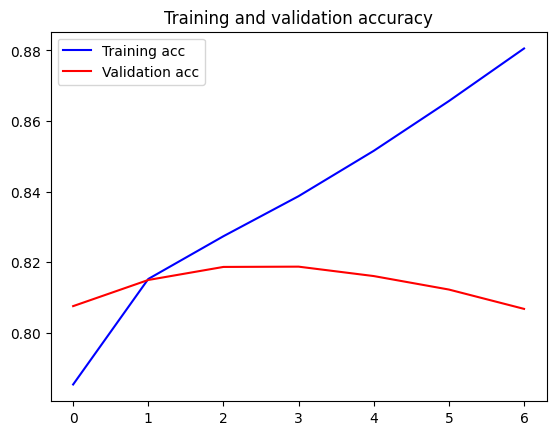

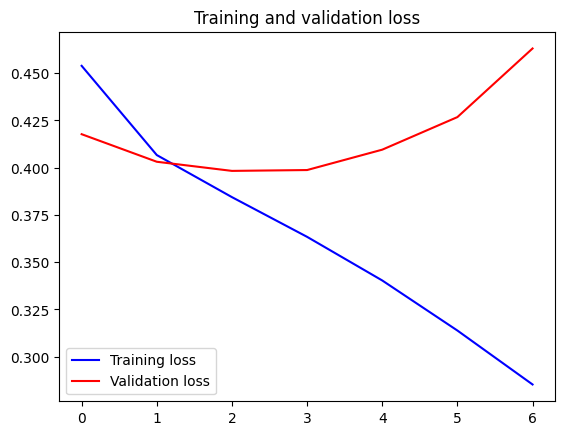

CPU times: user 1h 30min 30s, sys: 18min 15s, total: 1h 48min 46s
Wall time: 1h 6min 19s


In [8]:
%%time

tf.config.get_visible_devices()

# Constants
MAXLEN = 200
VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 50
# liste des choix possibles : 

# model_config = {
# 'model_type': 'CNN','LSTM',
# 'preprocessing': 'aucun', 'simple','advanced', 'advanced_lemma',
# 'metrics': ['accuracy', 'auc'],
# 'embeddings' :  "./glove.twitter.27B.[25,50,200]d.txt", ""./GoogleNews-vectors-negative300.bin"
# 'n_sample' : 1600000,O
# }
# os.environ["OMP_NUM_THREADS"] = "16"

model_config = {
                'model_type': 'CNN',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "aucun",   
                'n_sample' : 1600000,
                'l_r' : 0.00005,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
with tf.device('/device:cpu:0'):
    model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)  

Nous obtenons :

* Test_Accuracy 0.8077

* Test_Auc 0.8879

## Modele avec preprocessing simple

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

switchfoot http //twitpic.com/2y1zl awww 's bummer shoulda got david carr third day

upset ca n't update facebook texting ... might cry result school today also blah

kenichan dived many times ball managed save 50 rest go bounds

x_train shape : 1280000
y_train shape : 1280000
x_test shape : 320000
y_test shape : 320000
Begining vectorizer.adapt() 


2024-09-10 01:46:36.989337: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20002
Building model ...
model_type :	 CNN
preprocessing :	 simple
pre_trained_embeddings :	 aucun
n_sample :	 1600000
l_r :	 5e-05
aucun
False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 65, 128)        │        89,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,221,385 (8.47 MB)

 Trainable params: 2,221,385 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...
Epoch 1/50
31998/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7285 - loss: 0.5201
Epoch 1: val_loss improved from inf to 0.44430, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 312s 10ms/step - accuracy: 0.7285 - loss: 0.5201 - val_accuracy: 0.7904 - val_loss: 0.4443
Epoch 2/50
31997/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7985 - loss: 0.4358
Epoch 2: val_loss improved from 0.44430 to 0.43616, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 310s 10ms/step - accuracy: 0.7985 - loss: 0.4358 - val_accuracy: 0.7951 - val_loss: 0.4362
Epoch 3/50
31998/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8084 - loss: 0.4169
Epoch 3: val_loss improved from 0.43616 to 0.43468, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 319s 10ms/step - accuracy: 0.8084 - loss: 0.4169 - val_accuracy: 0.7969 - val_loss: 0.4347
Epoch 4/50
31995/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 

2024/09/10 02:23:10 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/10 02:23:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/09/10 02:23:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run CNN_simple_aucun at: http://0.0.0.0:8000/#/experiments/0/runs/da1befe4b06a4a218339140a247ad0b3.
2024/09/10 02:23:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:8000/#/experiments/0.


Test_Accuracy 0.7791
Test_Auc 0.8582


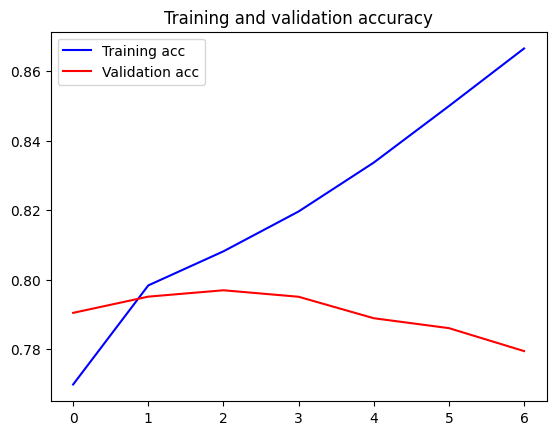

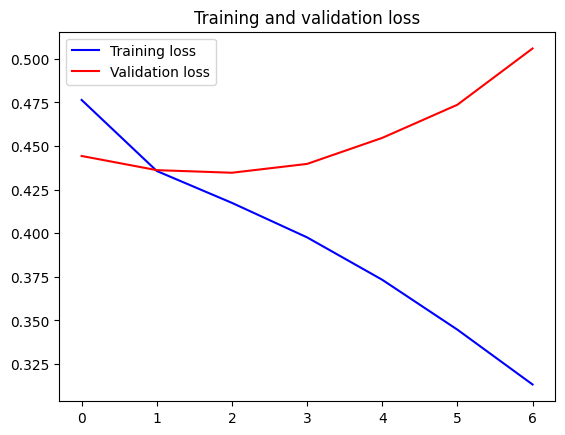

In [9]:

    
model_config = {
                'model_type': 'CNN',
                'preprocessing': 'simple',
                'pre_trained_embeddings' :  "aucun",   
                'n_sample' : 1600000,
                'l_r' : 0.00005,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
model = build_model()
with tf.device('/device:cpu:0'):
    compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)

Nous obtenons :

* Test_Accuracy 0.779

* Test_Auc 0.85

On observe une baisse de performance importante.

## Modele avec preprocessing avancé

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

switchfoot awww thats bummer shoulda got david carr third day

upset cant update facebook texting might cry result school today also blah

kenichan dived many times ball managed save rest go bounds

x_train shape : 1280000
y_train shape : 1280000
x_test shape : 320000
y_test shape : 320000
Begining vectorizer.adapt() 
20002
Building model ...
model_type :	 CNN
preprocessing :	 advanced
pre_trained_embeddings :	 aucun
n_sample :	 1600000
l_r :	 5e-05
aucun
False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 65, 128)        │        89,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,221,385 (8.47 MB)

 Trainable params: 2,221,385 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...
Epoch 1/50
31996/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7301 - loss: 0.5200
Epoch 1: val_loss improved from inf to 0.44858, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 335s 10ms/step - accuracy: 0.7301 - loss: 0.5200 - val_accuracy: 0.7876 - val_loss: 0.4486
Epoch 2/50
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7943 - loss: 0.4421
Epoch 2: val_loss improved from 0.44858 to 0.43996, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 356s 11ms/step - accuracy: 0.7943 - loss: 0.4421 - val_accuracy: 0.7925 - val_loss: 0.4400
Epoch 3/50
31997/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8050 - loss: 0.4224
Epoch 3: val_loss improved from 0.43996 to 0.43837, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 330s 10ms/step - accuracy: 0.8050 - loss: 0.4224 - val_accuracy: 0.7945 - val_loss: 0.4384
Epoch 4/50
31999/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accura

2024/09/10 03:33:14 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/10 03:33:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/09/10 03:33:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run CNN_advanced_aucun at: http://0.0.0.0:8000/#/experiments/0/runs/d72aee4cf8fa4ce38d198783ea9a413f.
2024/09/10 03:33:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:8000/#/experiments/0.


Test_Accuracy 0.7761
Test_Auc 0.8557


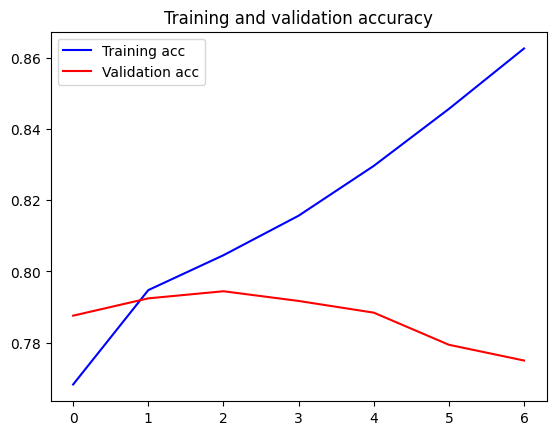

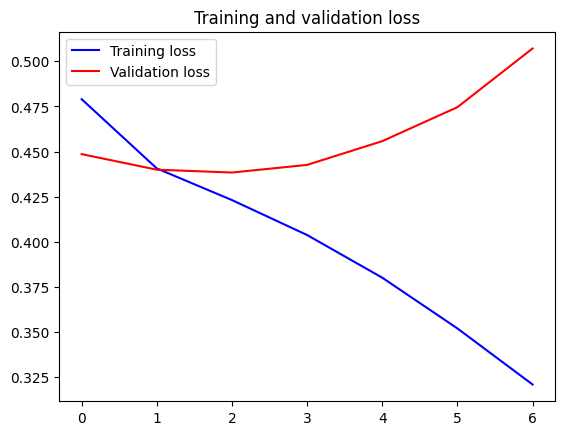

In [10]:
model_config = {
                'model_type': 'CNN',
                'preprocessing': 'advanced',
                'pre_trained_embeddings' :  "aucun",   
                'n_sample' : 1600000,
                'l_r' : 0.00005,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
with tf.device('/device:cpu:0'):
    model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)

Nous obtenons :

* Test_Accuracy 0.776

* Test_Auc 0.855

On observe une baisse de performance importante.

## Modele avec preprocessing avancé et lemmatization

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

switchfoot awww thats bummer shoulda get david carr third day

upset cant update facebook texting might cry result school today also blah

kenichan dive many time ball manage save rest go bound

x_train shape : 1280000
y_train shape : 1280000
x_test shape : 320000
y_test shape : 320000
Begining vectorizer.adapt() 


2024-09-10 04:06:51.039275: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20002
Building model ...
model_type :	 CNN
preprocessing :	 advanced_lemma
pre_trained_embeddings :	 aucun
n_sample :	 1600000
l_r :	 5e-05
aucun
False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 65, 128)        │        89,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,221,385 (8.47 MB)

 Trainable params: 2,221,385 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...
Epoch 1/50
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7269 - loss: 0.5250
Epoch 1: val_loss improved from inf to 0.45570, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 309s 10ms/step - accuracy: 0.7269 - loss: 0.5250 - val_accuracy: 0.7844 - val_loss: 0.4557
Epoch 2/50
31997/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7908 - loss: 0.4480
Epoch 2: val_loss improved from 0.45570 to 0.44661, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 310s 10ms/step - accuracy: 0.7908 - loss: 0.4480 - val_accuracy: 0.7882 - val_loss: 0.4466
Epoch 3/50
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8010 - loss: 0.4278
Epoch 3: val_loss improved from 0.44661 to 0.44450, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 346s 11ms/step - accuracy: 0.8010 - loss: 0.4278 - val_accuracy: 0.7894 - val_loss: 0.4445
Epoch 4/50
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy

2024/09/10 04:47:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/10 04:47:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/09/10 04:47:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run CNN_advanced_lemma_aucun at: http://0.0.0.0:8000/#/experiments/0/runs/8e4db811de1540c7b3e01769cc25024f.
2024/09/10 04:47:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:8000/#/experiments/0.


Test_Accuracy 0.7733
Test_Auc 0.8518


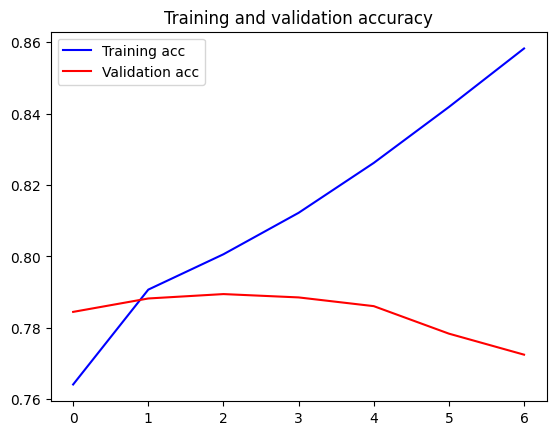

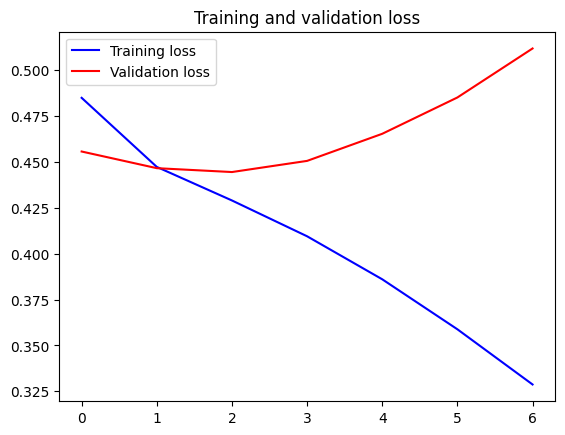

In [11]:
model_config = {
                'model_type': 'CNN',
                'preprocessing': 'advanced_lemma',
                'pre_trained_embeddings' :  "aucun",   
                'n_sample' : 1600000,
                'l_r' : 0.00005,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
with tf.device('/device:cpu:0'):
    model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)

Nous obtenons :

* Test_Accuracy 0.773

* Test_Auc 0.851

On observe une baisse de performance importante.

# Modele pré entrainé avec "glove.twitter.27B.200d.txt"

source : https://keras.io/examples/nlp/pretrained_word_embeddings/

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

x_train shape : 1280000
y_train shape : 1280000
x_test shape : 320000
y_test shape : 320000
Begining vectorizer.adapt() 
20002
Building model ...
model_type :	 CNN
preprocessing :	 aucun
pre_trained_embeddings :	 glove200
n_sample :	 1600000
l_r :	 0.0001
glove200
True
Loading 1193514 word vectors from glove.


20000

['', '[UNK]', 'i', 'to', 'the']

20002
Converted 17251 words (2749 misses), 86 %


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 200)       │     4,000,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 65, 128)        │       179,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,311,185 (16.45 MB)

 Trainable params: 4,311,185 (16.45 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...
Epoch 1/50
   11/32000 ━━━━━━━━━━━━━━━━━━━━ 5:44 11ms/step - accuracy: 0.5218 - loss: 0.6948   

W0000 00:00:1725938136.856396  478938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938136.856997  478938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938136.857482  478938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938136.857991  478938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938136.858466  478938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938136.859058  478938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938136.859530  478938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938136.860030  478938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938136.860447  478938 gp

31998/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7720 - loss: 0.4718

W0000 00:00:1725938483.021395  478933 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938483.022223  478933 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938483.022891  478933 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938483.023564  478933 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938483.024329  478933 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938483.025110  478933 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938483.025844  478933 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938483.026714  478933 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725938483.027489  478933 gp


Epoch 1: val_loss improved from inf to 0.40740, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 379s 12ms/step - accuracy: 0.7720 - loss: 0.4718 - val_accuracy: 0.8127 - val_loss: 0.4074
Epoch 2/50
31997/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8208 - loss: 0.3953
Epoch 2: val_loss improved from 0.40740 to 0.39619, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 378s 12ms/step - accuracy: 0.8208 - loss: 0.3953 - val_accuracy: 0.8195 - val_loss: 0.3962
Epoch 3/50
31997/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8366 - loss: 0.3658
Epoch 3: val_loss improved from 0.39619 to 0.39510, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 378s 12ms/step - accuracy: 0.8366 - loss: 0.3658 - val_accuracy: 0.8215 - val_loss: 0.3951
Epoch 4/50
31996/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8484 - loss: 0.3411
Epoch 4: val_loss did not improve from 0.39510
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 377s 12ms/step - accura

2024/09/10 06:00:14 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/10 06:00:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/09/10 06:00:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run CNN_aucun_glove200 at: http://0.0.0.0:8000/#/experiments/0/runs/9931f8a6729a4f9f8aa4aaee789a7c8a.
2024/09/10 06:00:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:8000/#/experiments/0.


Test_Accuracy 0.8102
Test_Auc 0.8884


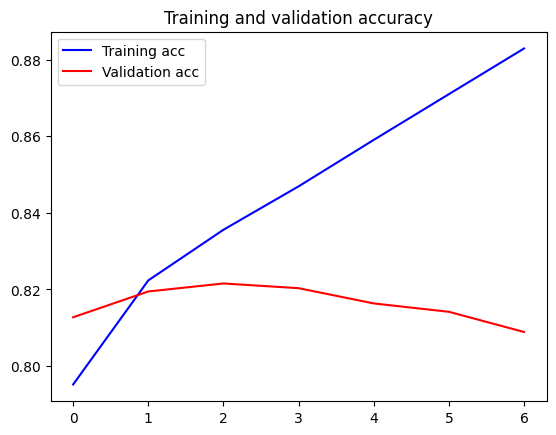

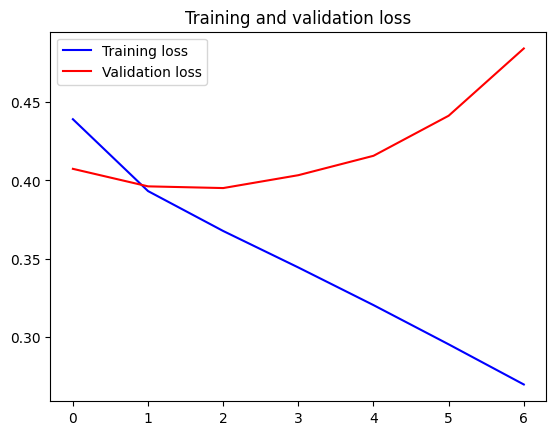

CPU times: user 1h 55min 32s, sys: 19min 6s, total: 2h 14min 38s
Wall time: 1h 13min 15s


In [12]:
%%time 

model_config = {
                'model_type': 'CNN',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "glove200",   
                'n_sample' : 1600000,
                'l_r' : 0.0001,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
with tf.device('/device:cpu:0'):
    model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)

Nous obtenons :

* Test_Accuracy 0.810

* Test_Auc 0.888

Pour le moment, nous avons ici nos meilleurs résultats.

# Modele pré entrainé avec "GoogleNews-vectors-negative300.bin"

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

x_train shape : 1280000
y_train shape : 1280000
x_test shape : 320000
y_test shape : 320000
Begining vectorizer.adapt() 
20002
Building model ...
model_type :	 CNN
preprocessing :	 aucun
pre_trained_embeddings :	 google300
n_sample :	 1600000
l_r :	 0.0001
google300
False
 0
[UNK] 1
i 2
to 3
the 4
Converted 15882 words (0 misses), 100 %


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 300)       │     6,000,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 65, 128)        │       268,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,400,985 (24.42 MB)

 Trainable params: 6,400,985 (24.42 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...
Epoch 1/50
    9/32000 ━━━━━━━━━━━━━━━━━━━━ 7:31 14ms/step - accuracy: 0.5045 - loss: 0.6938   

W0000 00:00:1725942541.119289  478935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942541.119939  478935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942541.120452  478935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942541.121050  478935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942541.121583  478935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942541.122101  478935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942541.122656  478935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942541.123292  478935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942541.123835  478935 gp

31996/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7735 - loss: 0.4688

W0000 00:00:1725942934.658753  478926 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942934.659469  478926 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942934.660011  478926 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942934.660547  478926 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942934.661103  478926 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942934.661641  478926 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942934.662220  478926 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942934.662925  478926 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725942934.663436  478926 gp


Epoch 1: val_loss improved from inf to 0.40331, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 431s 13ms/step - accuracy: 0.7735 - loss: 0.4688 - val_accuracy: 0.8156 - val_loss: 0.4033
Epoch 2/50
31998/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8258 - loss: 0.3858
Epoch 2: val_loss improved from 0.40331 to 0.39289, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 432s 14ms/step - accuracy: 0.8258 - loss: 0.3858 - val_accuracy: 0.8219 - val_loss: 0.3929
Epoch 3/50
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8460 - loss: 0.3476
Epoch 3: val_loss did not improve from 0.39289
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 429s 13ms/step - accuracy: 0.8460 - loss: 0.3476 - val_accuracy: 0.8207 - val_loss: 0.3984
Epoch 4/50
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8673 - loss: 0.3055
Epoch 4: val_loss did not improve from 0.39289
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 427s 13ms/step - accuracy: 0.8673 - loss: 0.3055 - val_accura

2024/09/10 07:12:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/10 07:12:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/09/10 07:12:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run CNN_aucun_google300 at: http://0.0.0.0:8000/#/experiments/0/runs/0d1b1192fa524706aa04e2c4bfea270b.
2024/09/10 07:12:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:8000/#/experiments/0.


Test_Accuracy 0.8017
Test_Auc 0.878


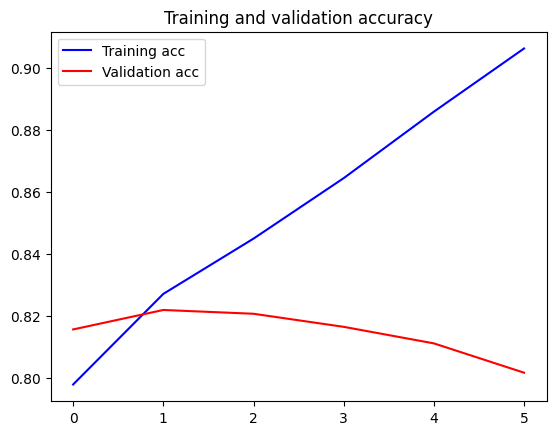

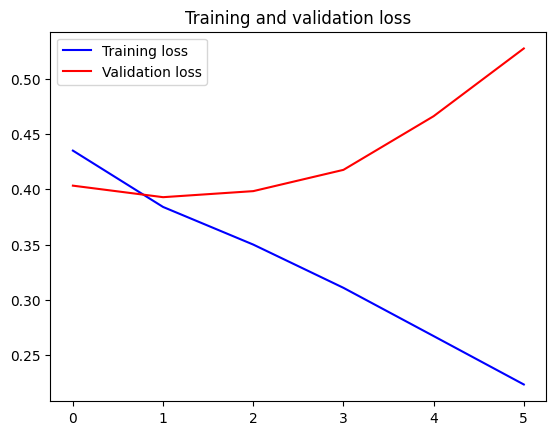

CPU times: user 2h 2min 54s, sys: 16min 27s, total: 2h 19min 21s
Wall time: 1h 12min 24s


In [13]:
%%time 

model_config = {
                'model_type': 'CNN',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "google300",   
                'n_sample' : 1600000,
                'l_r' : 0.0001,
                }

x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
with tf.device('/device:cpu:0'):
    model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)


Nous obtenons :

* Test_Accuracy 0.801

* Test_Auc 0.878

L'embedding glove est meilleur que l'embedding google.

# Modèle LSTM bidirectionnel sans pre trained embedding

source : https://keras.io/examples/nlp/bidirectional_lstm_imdb/

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

x_train shape : 1280000
y_train shape : 1280000
x_test shape : 320000
y_test shape : 320000
Begining vectorizer.adapt() 


2024-09-10 23:48:21.437918: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20002
Building model ...
model_type :	 LSTM
preprocessing :	 aucun
pre_trained_embeddings :	 aucun
n_sample :	 1600000
l_r :	 5e-05
aucun
False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,183,625 (8.33 MB)

 Trainable params: 2,183,625 (8.33 MB)

 Non-trainable params: 0 (0.00 B)

Compiling model ...
Start training ...
Epoch 1/50


2024-09-10 23:48:24.177109: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


31999/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7613 - loss: 0.4867
Epoch 1: val_loss improved from inf to 0.42759, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 1658s 52ms/step - accuracy: 0.7613 - loss: 0.4867 - val_accuracy: 0.8017 - val_loss: 0.4276
Epoch 2/50
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8088 - loss: 0.4151
Epoch 2: val_loss improved from 0.42759 to 0.41105, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 1614s 50ms/step - accuracy: 0.8088 - loss: 0.4151 - val_accuracy: 0.8107 - val_loss: 0.4110
Epoch 3/50
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8185 - loss: 0.3972
Epoch 3: val_loss improved from 0.41105 to 0.40348, saving model to best_model.keras
32000/32000 ━━━━━━━━━━━━━━━━━━━━ 1604s 50ms/step - accuracy: 0.8185 - loss: 0.3972 - val_accuracy: 0.8147 - val_loss: 0.4035
Epoch 4/50
31999/32000 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8247 - loss: 0.3861
Epoch 4: val_loss imp

2024/09/11 04:22:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/11 04:22:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/09/11 04:22:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTM_aucun_aucun at: http://0.0.0.0:8000/#/experiments/0/runs/4b68dee54fd84903ae719b9f88839a09.
2024/09/11 04:22:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://0.0.0.0:8000/#/experiments/0.


Test_Accuracy 0.819
Test_Auc 0.8999


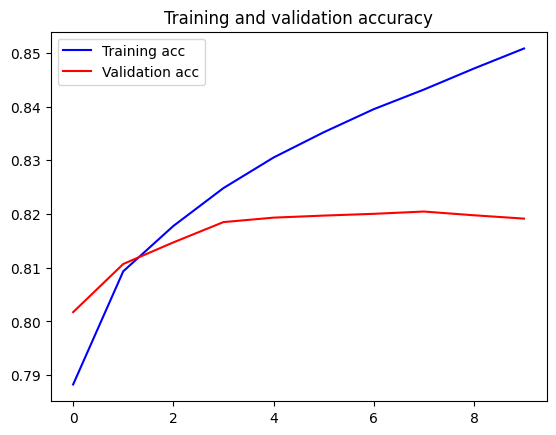

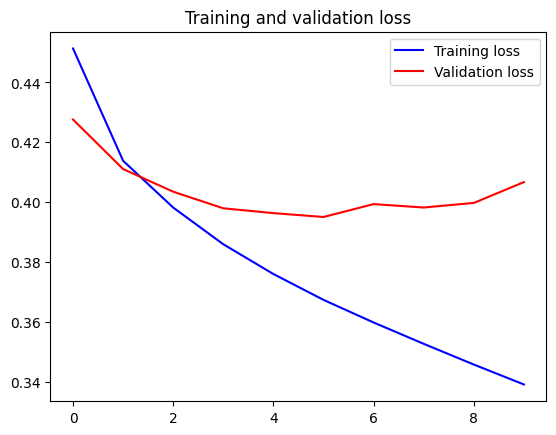

CPU times: user 4h 23min 4s, sys: 1h 22min, total: 5h 45min 4s
Wall time: 5h 3min 7s


In [8]:
%%time

model_config = {
                'model_type': 'LSTM',
                'preprocessing': 'aucun',
                'pre_trained_embeddings' :  "aucun",
                'n_sample' : 1600000,
                'l_r' : 0.00005,
                }
x_train, y_train, x_test, y_test = prepro_data(df, 'text', 'labels')
with tf.device('/device:cpu:0'):
    model = build_model()
compile_model(model)
history = train_eval_model(model, x_train, y_train, x_test, y_test)
plot_metrics(history)




Nous obtenons :

* Test_Accuracy 0.819

* Test_Auc 0.899

Les résultats sont légèrements plus élevés qu'avec l'embedding glove. Les temps de calculs sont également plus élevés.


# Modèle BERT

Dans cette partie nous réalisons l'étude avec le modèle BERT.

In [5]:
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import TFAutoModelForSequenceClassification


from datasets import Dataset, load_dataset

import keras

model_config = {
                'model_type': 'BERTtf',
                'preprocessing': "google-bert/bert-base-cased",
                'pre_trained_embeddings' :  "aucun",
                'n_sample' : 1600000,
                'l_r' : 0.00002,
                }




df_sample = df.sample(n=model_config['n_sample'], random_state=42)

df_sample = df_sample[['labels','text']]
print("train_test_split")

df_sample_train, df_sample_test = train_test_split(df_sample, test_size=0.2, random_state=42)

print("Dataset.from_pandas(")
ds_train = Dataset.from_pandas(df_sample_train,preserve_index=False)
ds_test = Dataset.from_pandas(df_sample_test,preserve_index=False)

print("AutoTokenizer")
tokenizer = AutoTokenizer.from_pretrained(model_config['preprocessing'])


def tokenize_function(examples):
    return tokenizer(
                        examples["text"],
                        padding="max_length",   # Force padding
                        max_length=50,          # Set the max length for padding
                        truncation=True,        # Truncate if the sequence is longer than max_length
                        return_tensors="np"     # Return as PyTorch tensors (can be 'tf' for TensorFlow)
                    )

tokenized_data_train = ds_train.map(tokenize_function, batched=True, remove_columns=ds_train.column_names)

# Convert to a TensorFlow-compatible format
tokenized_data_train.set_format(type='numpy', columns=['input_ids', 'attention_mask', 'token_type_ids'])

# Extract the tokenized data as NumPy arrays
input_ids_train = np.array(tokenized_data_train['input_ids'])
attention_mask_train = np.array(tokenized_data_train['attention_mask'])

tokenized_data_test = ds_test.map(tokenize_function, batched=True, remove_columns=ds_test.column_names)
tokenized_data_test.set_format(type='numpy', columns=['input_ids', 'attention_mask', 'token_type_ids'])
input_ids_test = np.array(tokenized_data_test['input_ids'])
attention_mask_test = np.array(tokenized_data_test['attention_mask'])



y_train = np.array(ds_train["labels"])  # Label is already an array of 0 and 1
y_test = np.array(ds_test["labels"])  # Label is already an array of 0 and 1

# Load and compile our model
with mlflow.start_run(run_name=model_config['model_type'] + '_' + model_config['preprocessing'] + '_' + model_config['pre_trained_embeddings']):
    print("TFAutoModelForSequenceClassification")
    model = TFAutoModelForSequenceClassification.from_pretrained(model_config['preprocessing'])
    print("compile")
    model.summary() 
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=model_config['l_r']),
                  metrics=['accuracy'])
    print("fit")
    model.fit({'input_ids': input_ids_train, 'attention_mask': attention_mask_train}, y_train)

    # Make predictions on the test data
    predictions = model.predict({'input_ids': input_ids_test, 'attention_mask': attention_mask_test})
    
    # Convert predictions to probabilities and classes
    predicted_probs = tf.nn.softmax(predictions.logits, axis=-1)
    y_pred = tf.argmax(predicted_probs, axis=1).numpy()
    
    display(y_test)
    display(y_pred)
    display(predicted_probs)
    # Calculate sklearn metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, predicted_probs[:, 1])

    # Log metrics
    mlflow.keras.log_model(model, "model")        
    mlflow.log_metric("Test Accuracy", accuracy)
    mlflow.log_metric("Test Auc", auc)
    mlflow.log_params(model_config)  # Log model configuration


train_test_split
Dataset.from_pandas(


/home/cc/miniconda3/envs/tf_312/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


AutoTokenizer


Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320000/320000 [00:05<00:00, 63483.65 examples/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...


TFAutoModelForSequenceClassification


I0000 00:00:1726146297.123210   55165 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726146297.207251   55165 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726146297.207289   55165 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726146297.208781   55165 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726146297.208810   55165 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

compile
Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
fit


I0000 00:00:1726146308.735441   57192 service.cc:146] XLA service 0x7f78d7b497a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726146308.735467   57192 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2024-09-12 15:05:08.745568: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-12 15:05:08.764710: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1726146308.823369   57192 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10000/10000 [==============================] - 187s 19ms/step


array([0, 1, 0, ..., 0, 0, 0])

array([0, 1, 0, ..., 0, 1, 0])

<tf.Tensor: shape=(320000, 2), dtype=float32, numpy=
array([[0.8779773 , 0.12202264],
       [0.1761563 , 0.8238437 ],
       [0.8471629 , 0.15283708],
       ...,
       [0.71760356, 0.28239638],
       [0.01142566, 0.9885744 ],
       [0.9336445 , 0.0663555 ]], dtype=float32)>

2024/09/12 15:55:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
/home/cc/miniconda3/envs/tf_312/lib/python3.12/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024/09/12 15:56:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpas9o2qk1/model, flavor: keras). Fall back to return ['keras==3.5.0']. Set logging level to DEBUG to see the full traceback. 
2024/09/1

Nous obtenons (voir mlflow):

* Test_Accuracy 0.866

* Test_Auc 0.941

Le modèle BERT permet d'obtenir une accuracy et un auc de très bonne qualité en comparaison aux autres algorythmes.